# Justify aperiodic mode

### Set path

In [1]:
PROJECT_PATH = 'C:/Users/micha/projects/oscillation_vs_exponent/'

## Set-up

### Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams


In [3]:
from fooof import FOOOFGroup, FOOOF
# from fooof.bands import Bands
# from fooof.analysis import get_band_peak_fg
# from fooof.utils import trim_spectrum


In [4]:
import sys
sys.path.append(f"{PROJECT_PATH}/code")
# from plots import 
from utils import compute_adj_r2


### Settings

In [5]:
# dataset details
FS = 512 # sampling frequency
TMIN = -1.5 # epoch start time
PATIENTS = ['pat02','pat04','pat05','pat08','pat10','pat11','pat15','pat16',
            'pat17','pat19','pat20','pat21','pat22'] # subject IDs


In [6]:
# analysis settings

# power analysis settings
WINDOW = 0.3 # for spectral decomp
TFR_METHOD = 'multitaper' # 'morlet' or 'multitaper'

# band anlysis
# BANDS = Bands({'alpha' : [8, 20]})
ALPHA_BAND = [8, 20]

# Specparam parameters
N_JOBS = -1 # number of jobs for parallel processing
SPEC_PARAM_SETTINGS = {
    'peak_width_limits' :   [4, 20], # default: (0.5, 12.0)) - reccomends at least frequency resolution * 2
    'min_peak_height'   :   0.1, 
    'max_n_peaks'       :   4, # (default: inf)
    'peak_threshold'    :   2.0, # (default: 2.0)
    'aperiodic_mode'    :   'knee'}
AP_MODE = 'knee'

In [7]:
# Matplotlib rcParams

# font/text size
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 16
rcParams['legend.fontsize'] = 12

# saving
rcParams['savefig.dpi'] = 300
rcParams['savefig.facecolor'] = 'w'

### Functions

## Main

### Compare r-squared between aperiodic modes

Mean r-squared values for each model across all conditions:
Knee: 	0.983
Fixed: 	0.979


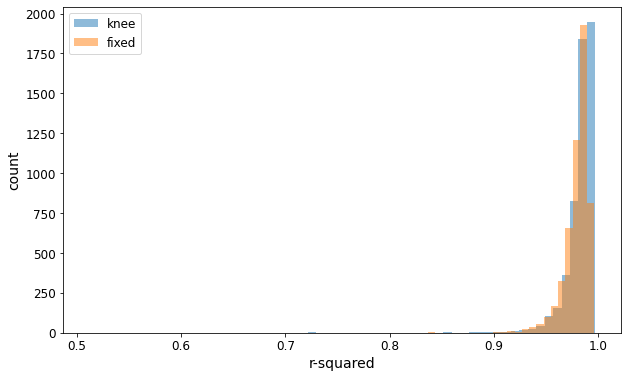

In [8]:
# Import r-squared values for each aperiodic model across all conditions

# init
r2_knee = []
r2_fixed = []

for material in ['words','faces']:
    for memory in ['hit','miss']:
        for window in ['pre', 'post']:
            # load r-squared values for 'knee' model
            fg_k = FOOOFGroup()
            fg_k.load(f'{PROJECT_PATH}/data/ieeg_psd_param/{material}_{memory}_{window}stim_params_knee')
            # r2_k = fg_k.get_params('r_squared')
            r2_k = compute_adj_r2(fg_k)
            r2_knee.append(r2_k)

            # load r-squared values for 'fixed' model
            fg_f = FOOOFGroup()
            fg_f.load(f'{PROJECT_PATH}/data/ieeg_psd_param/{material}_{memory}_{window}stim_params_fixed')
            # r2_f = fg_f.get_params('r_squared')
            r2_f = compute_adj_r2(fg_f)
            r2_fixed.append(r2_f)

# concatenate
r2_knee = np.concatenate(r2_knee)
r2_fixed = np.concatenate(r2_fixed)

# print mean
print("Mean r-squared values for each model across all conditions:")
print(f"Knee: \t{np.nanmean(r2_knee):.3f}")
print(f"Fixed: \t{np.nanmean(r2_fixed):.3f}")

# plot histogram of results
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(r2_knee, bins=60, alpha=0.5, label='knee')
ax.hist(r2_fixed, bins=60, alpha=0.5, label='fixed')
ax.set(xlabel="r-squared", ylabel="count")
ax.legend()

plt.show()


In [9]:
# there are a few outliers with poor fits 

# print the min values
print("Min r-squared values:")
print(f"knee: {np.nanmin(r2_knee):.2f}, fixed: {np.nanmin(r2_fixed):.2f}")

# print the number/percentage of fits with r-squred less than 0.9 for each model
print("\nNumber of fits with r-squared less than 0.9:")
print(f"knee: {np.sum(r2_knee < 0.9)}, fixed: {np.sum(r2_fixed < 0.9)}")
print("\nPercentage of fits with r-squared less than 0.9:")
print(f"knee: {np.sum(r2_knee < 0.9)/len(r2_knee)*100:.2f}%, fixed: {np.sum(r2_fixed < 0.9)/len(r2_fixed)*100:.2f}%")

Min r-squared values:
knee: 0.51, fixed: 0.58

Number of fits with r-squared less than 0.9:
knee: 21, fixed: 21

Percentage of fits with r-squared less than 0.9:
knee: 0.38%, fixed: 0.38%


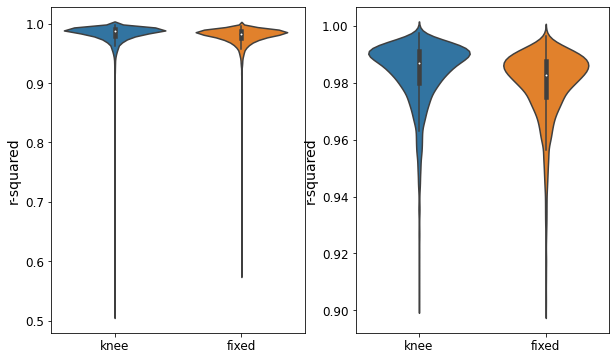

In [10]:
# plot violin plot of r-suared results
import seaborn as sns

# remove nan
r2_knee_ = r2_knee[~np.isnan(r2_knee)]
r2_fixed_ = r2_fixed[~np.isnan(r2_fixed)]

# plot
fig, (ax, ax_zoom) = plt.subplots(1,2, figsize=(10, 6))
# ax.violinplot([r2_knee_, r2_fixed_], showmeans=True, )
sns.violinplot(data=[r2_knee_, r2_fixed_], ax=ax)
ax.set(xticks=[0, 1], xticklabels=['knee', 'fixed'], ylabel="r-squared")

# plot - remove outliers 
sns.violinplot(data=[r2_knee_[r2_knee_>.9], r2_fixed_[r2_fixed_>.9]], ax=ax_zoom)
ax_zoom.set(xticks=[0, 1], xticklabels=['knee', 'fixed'], ylabel="r-squared")

plt.show()

Mean difference: 0.004
Percent with positive difference: 0.728


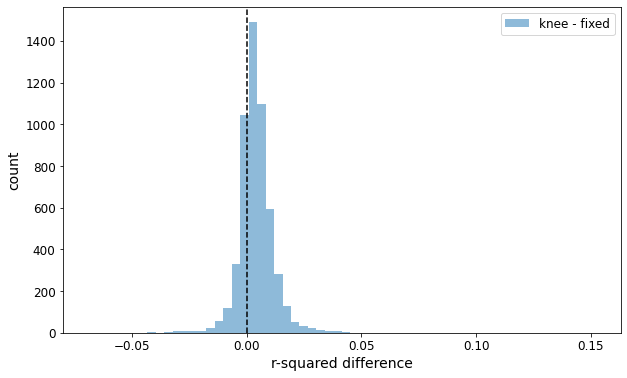

In [11]:
# compute difference in r-squared betwen models
r2_diff = r2_knee - r2_fixed
print(f"Mean difference: {np.nanmean(r2_diff):.3f}")
print(f"Percent with positive difference: {np.sum(r2_diff > 0) / len(r2_diff):.3f}")

# plot histogram of results
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(r2_diff, bins=60, alpha=0.5, label='knee - fixed')
ax.set(xlabel="r-squared difference", ylabel="count")
ax.axvline(0, color='k', linestyle='--')
ax.legend();

Although the difference in r-squared between models is small, when we compared r-squared values on a  channel-by-channel basis, 73% of channels exhibit greater r-squared values when fit with the 'knee' model.

### Fit grand-average PSD with both apeiodic modes

spectra_cond shape: (8, 98)
psd shape: (98,)


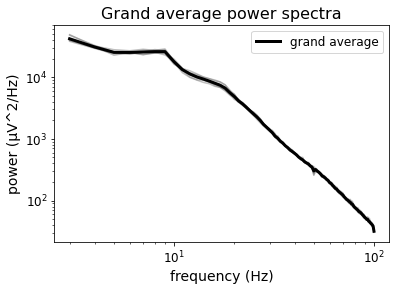

In [12]:
# load all PSDs
dir_input = f'{PROJECT_PATH}/data/ieeg_spectral_results'
files = [f for f in os.listdir(dir_input) if (('psd' in f) and ('.npz' in f))]

# init
temp = np.load(f"{dir_input}/{files[0]}")
spectra = np.zeros([len(files), temp['spectra'].shape[0], temp['spectra'].shape[1]])
freq = temp['freq']
del temp

# load spectra for each condition
for i_file, fname_in in enumerate(files):
    data_in = np.load(f"{dir_input}/{fname_in}")
    spectra[i_file] = data_in['spectra']
    
# average over channels and compute granda verage
spectra_cond = np.nanmean(spectra, axis=1)
psd = np.nanmean(spectra_cond, axis=0)
print(f"spectra_cond shape: {spectra_cond.shape}")
print(f"psd shape: {psd.shape}")

# plot
fig, ax = plt.subplots()
ax.loglog(freq, spectra_cond.T, color='grey', alpha=0.5)
ax.loglog(freq, psd, label='grand average', color='k', linewidth=3)
ax.set(xlabel="frequency (Hz)", ylabel="power (\u03BCV^2/Hz)")
ax.set_title("Grand average power spectra")
ax.legend();


In [13]:
# fit power spectra with both aperiodic modes and compre r-squared

# settings
specparam_settings = SPEC_PARAM_SETTINGS.copy()
del specparam_settings['aperiodic_mode']

# fit 'knee'
fg_k = FOOOF(aperiodic_mode='knee', **specparam_settings)
fg_k.fit(freq, psd)
# r2_k = fg_k.get_params('r_squared')
r2_k = compute_adj_r2(fg_k)

# fit 'fixed'
fg_f = FOOOF(aperiodic_mode='fixed', **specparam_settings)
fg_f.fit(freq, psd)
# r2_f = fg_f.get_params('r_squared')
r2_f = compute_adj_r2(fg_f)

# print
print(f"r-squared values for each model:")
print(f"Knee: \t{r2_k:.3f}")
print(f"Fixed: \t{r2_f:.3f}")


r-squared values for each model:
Knee: 	0.998
Fixed: 	0.983


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          5.8662, 2.0636                                          
                                                                                                  
                                       1 peaks were found:                                        
          

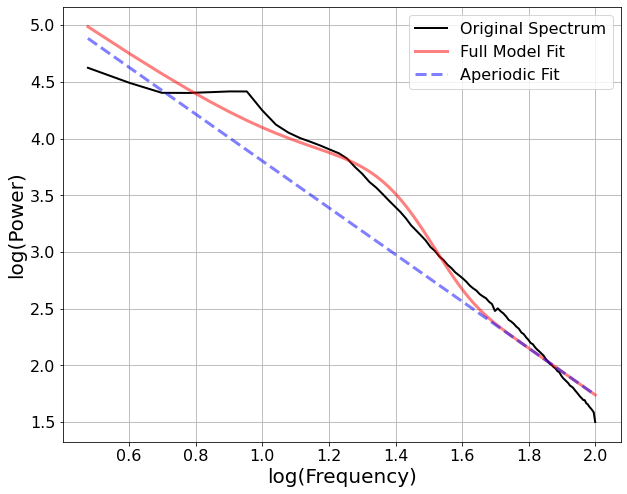

In [14]:
# show report - fixed
fg_f.report(plt_log=True)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    7.6383, 1442.1472, 3.0198                                     
                                                                                                  
                                       1 peaks were found:                                        
          

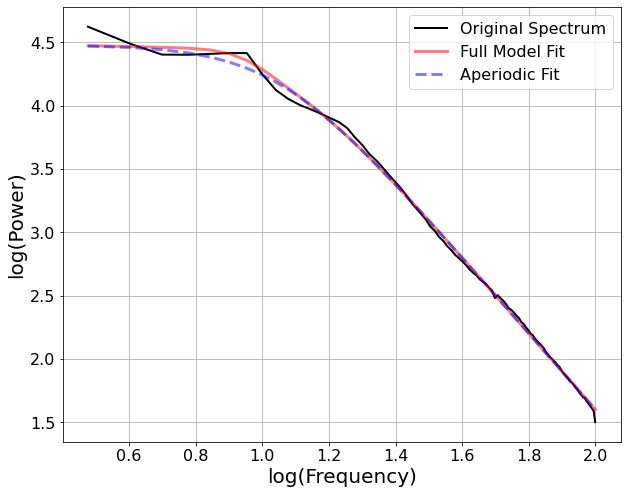

In [15]:
# show report - knee
fg_k.report(plt_log=True)

This analysis demonstrates that a high r-suared value does not necessarilly indicate a 'good' fit. Here we see the 'fixed' model has an r-squared value of 0.98, yet it does not capture the data well (fitting a broad peak to what appears to be a 'knee' component). Note: in general, we do not recommend fitting channel-averaged power spectra

### Summary Figure

Removed 21 outliers from knee model
Removed 20 outliers from fixed model


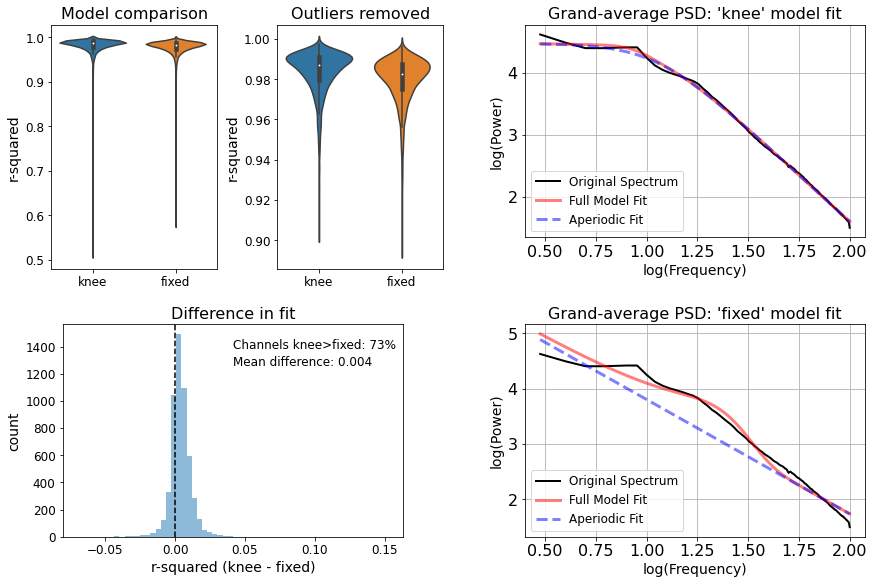

In [16]:
# create figure and gridspec
fig = plt.figure(figsize=[12,8], constrained_layout=True)
spec = gridspec.GridSpec(figure=fig, ncols=2, nrows=2, width_ratios=[1,1], height_ratios=[1,1],
                         wspace=0.2, hspace=0.1)
# ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[1,0])
ax3 = fig.add_subplot(spec[0,1])
ax4 = fig.add_subplot(spec[1,1])

# plot subplot 1 - violin ----------------------------------------------------------------------
# created nested gridspec
spec1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=spec[0,0], width_ratios=[1,1])
ax1a = fig.add_subplot(spec1[0,0])
ax1b = fig.add_subplot(spec1[0,1])

# remove outliers
outlier_thresh_knee = np.nanmean(r2_knee) - 5 * np.nanstd(r2_knee)
outlier_thresh_fixed = np.nanmean(r2_fixed) - 5 * np.nanstd(r2_fixed)
print(f"Removed {len(r2_knee_[r2_knee_<=outlier_thresh_knee])} outliers from knee model")
print(f"Removed {len(r2_fixed_[r2_fixed_<=outlier_thresh_fixed])} outliers from fixed model")

# plot
ax1a.set_title('Model comparison')
sns.violinplot(data=[r2_knee, r2_fixed], ax=ax1a)
ax1a.set(xticks=[0, 1], xticklabels=['knee', 'fixed'], ylabel="r-squared")

# plot - without outliers
ax1b.set_title('Model comparison \n (outliers removed)')
ax1b.set_title('Outliers removed')
sns.violinplot(data=[r2_knee_[r2_knee_>outlier_thresh_knee], 
                     r2_fixed_[r2_fixed_>outlier_thresh_fixed]], ax=ax1b)
ax1b.set(xticks=[0, 1], xticklabels=['knee', 'fixed'], ylabel="r-squared")

# plot subplot 2 - histogram ----------------------------------------------------------------------
# compute difference in r-squared betwen models
r2_diff = r2_knee - r2_fixed

# plot
ax2.hist(r2_diff, bins=60, alpha=0.5, label='knee - fixed')
ax2.set(xlabel="r-squared (knee - fixed)", ylabel="count")
ax2.axvline(0, color='k', linestyle='--')
ax2.set_title('Difference in fit')

# add text
ax2.text(0.5, 0.93, f"Channels knee>fixed: {np.sum(r2_diff > 0) / len(r2_diff)*100:.0f}%",
            horizontalalignment='left', verticalalignment='top',
            transform=ax2.transAxes, fontsize=12)
ax2.text(0.5, 0.85, f"Mean difference: {np.nanmean(r2_diff):.3f}",
            horizontalalignment='left', verticalalignment='top',
            transform=ax2.transAxes, fontsize=12)

# plot subplot 3 ----------------------------------------------------------------------
fg_k.plot(plt_log=True, ax=ax3)
ax3.legend(loc='lower left')
ax3.set_title("Grand-average PSD: 'knee' model fit")

# plot subplot 4 ----------------------------------------------------------------------
fg_f.plot(plt_log=True, ax=ax4)
ax4.legend(loc='lower left')
ax4.set_title("Grand-average PSD: 'fixed' model fit")

# adjust ax 3 and 4 fontsize to match rcParams
for ax in [ax3, ax4]:
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)